In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsbombpy import sb
import math
from mplsoccer import Pitch, Sbopen, VerticalPitch
from shapely.geometry import Point, Polygon

In [66]:
euros_matches = sb.matches(competition_id=55, season_id=282)
matches = euros_matches['match_id'].tolist()

shots1 = []

for i in matches:
    game_events = sb.events(match_id=i)
    shots = game_events[~game_events['shot_type'].isna()]
    shots1.append(shots)

shots_df = pd.concat(shots1, ignore_index=True)

shots_df = shots_df[~shots_df['shot_freeze_frame'].isna()]
player_location = pd.DataFrame(shots_df['shot_freeze_frame'].iloc[2])
player_location

,location,player,position,teammate
0,"[109.9, 30.6]","{'id': 3308, 'name': 'Kieran Trippier'}","{'id': 8, 'name': 'Left Wing Back'}",True
1,"[109.2, 40.2]","{'id': 4354, 'name': 'Phil Foden'}","{'id': 18, 'name': 'Right Attacking Midfield'}",True
2,"[106.0, 36.0]","{'id': 10955, 'name': 'Harry Kane'}","{'id': 23, 'name': 'Center Forward'}",True
3,"[104.8, 39.4]","{'id': 15503, 'name': 'Jerdy Schouten'}","{'id': 9, 'name': 'Right Defensive Midfield'}",False
4,"[102.0, 41.8]","{'id': 15582, 'name': 'Donyell Malen'}","{'id': 17, 'name': 'Right Wing'}",False
5,"[102.4, 40.5]","{'id': 30714, 'name': 'Jude Bellingham'}","{'id': 20, 'name': 'Left Attacking Midfield'}",True
6,"[90.7, 43.6]","{'id': 99174, 'name': 'Kobbie Mainoo'}","{'id': 9, 'name': 'Right Defensive Midfield'}",True
7,"[117.8, 40.4]","{'id': 37274, 'name': 'Bart Verbruggen'}","{'id': 1, 'name': 'Goalkeeper'}",False
8,"[108.0, 42.8]","{'id': 3669, 'name': 'Virgil van Dijk'}","{'id': 5, 'name': 'Left Center Back'}",False
9,"[108.0, 40.7]","{'id': 7787, 'name': 'Stefan de Vrij'}","{'id': 3, 'name': 'Right Center Back'}",False


In [67]:
shot = shots_df.iloc[2]
ball_location = shot['location']


for index, row in player_location.iterrows():
    distance = (((ball_location[0]-row['location'][0])**2)+(ball_location[1]-row['location'][1])**2)**(1/2)
    player_location.loc[index, 'distance'] = distance

teammates = player_location[player_location['teammate'] == True]
opponents = player_location[player_location['teammate'] == False]
teammates

,location,player,position,teammate,distance
0,"[109.9, 30.6]","{'id': 3308, 'name': 'Kieran Trippier'}","{'id': 8, 'name': 'Left Wing Back'}",True,12.253979
1,"[109.2, 40.2]","{'id': 4354, 'name': 'Phil Foden'}","{'id': 18, 'name': 'Right Attacking Midfield'}",True,4.904080
2,"[106.0, 36.0]","{'id': 10955, 'name': 'Harry Kane'}","{'id': 23, 'name': 'Center Forward'}",True,5.797413
5,"[102.4, 40.5]","{'id': 30714, 'name': 'Jude Bellingham'}","{'id': 20, 'name': 'Left Attacking Midfield'}",True,2.370654
6,"[90.7, 43.6]","{'id': 99174, 'name': 'Kobbie Mainoo'}","{'id': 9, 'name': 'Right Defensive Midfield'}",True,13.944174
14,"[102.7, 54.3]","{'id': 3205, 'name': 'Kyle Walker'}","{'id': 3, 'name': 'Right Center Back'}",True,12.826925


In [68]:
for index_t, row_t in teammates.iterrows():
    m1 = (ball_location[1]-row_t['location'][1])/(ball_location[0]-row_t['location'][0])
    m2 = (-1)/m1
    c1 = row_t['location'][1] - row_t['location'][0]*m1
    intercepted_list = []
    example_list = []
    for index_o, row_o in opponents.iterrows():
        c2 = row_o['location'][1] - row_o['location'][0]*m2
        crossover_x = (c2-c1)/(m1-m2)
        crossover_y = m1*crossover_x + c1
        ball_distance_to_crossover = (((ball_location[0]-crossover_x)**2)+(ball_location[1]-crossover_y)**2)**(1/2)
        player_distance_to_crossover = (((row_o['location'][0]-crossover_x)**2)+(row_o['location'][1]-crossover_y)**2)**(1/2)
        ball_time_to_crossover = ball_distance_to_crossover/12.2
        player_time_to_crossover = player_distance_to_crossover/6.84
        example_list.append(False)
        if row_t['location'][0] > ball_location[0]:
            if player_time_to_crossover < ball_time_to_crossover and crossover_x > ball_location[0] and crossover_x < row_t['location'][0]:
                intercepted_list.append(True)
            else:
                intercepted_list.append(False)
        elif row_t['location'][0] < ball_location[0]:
            if player_time_to_crossover < ball_time_to_crossover and crossover_x < ball_location[0] and crossover_x > row_t['location'][0]:
                intercepted_list.append(True)
            else:
                intercepted_list.append(False)
    
    print(intercepted_list)
    if not any(intercepted_list):
        teammates.loc[index_t, 'intercepted'] = False
    else:
        teammates.loc[index_t, 'intercepted'] = True

        
teammates

[True, False, False, False, False, True, False, False, False]
[False, False, False, False, True, False, True, False, False]
[True, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False]
[False, True, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False]


/var/folders/r2/l3m1j7vd1djg8cftzv5dx7200000gn/T/ipykernel_41458/2947482774.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teammates.loc[index_t, 'intercepted'] = True
/var/folders/r2/l3m1j7vd1djg8cftzv5dx7200000gn/T/ipykernel_41458/2947482774.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  teammates.loc[index_t, 'intercepted'] = True


,location,player,position,teammate,distance,intercepted
0,"[109.9, 30.6]","{'id': 3308, 'name': 'Kieran Trippier'}","{'id': 8, 'name': 'Left Wing Back'}",True,12.253979,True
1,"[109.2, 40.2]","{'id': 4354, 'name': 'Phil Foden'}","{'id': 18, 'name': 'Right Attacking Midfield'}",True,4.904080,True
2,"[106.0, 36.0]","{'id': 10955, 'name': 'Harry Kane'}","{'id': 23, 'name': 'Center Forward'}",True,5.797413,True
5,"[102.4, 40.5]","{'id': 30714, 'name': 'Jude Bellingham'}","{'id': 20, 'name': 'Left Attacking Midfield'}",True,2.370654,False
6,"[90.7, 43.6]","{'id': 99174, 'name': 'Kobbie Mainoo'}","{'id': 9, 'name': 'Right Defensive Midfield'}",True,13.944174,True
14,"[102.7, 54.3]","{'id': 3205, 'name': 'Kyle Walker'}","{'id': 3, 'name': 'Right Center Back'}",True,12.826925,False


In [69]:
opponents

,location,player,position,teammate,distance
3,"[104.8, 39.4]","{'id': 15503, 'name': 'Jerdy Schouten'}","{'id': 9, 'name': 'Right Defensive Midfield'}",False,2.220360
4,"[102.0, 41.8]","{'id': 15582, 'name': 'Donyell Malen'}","{'id': 17, 'name': 'Right Wing'}",False,2.507987
7,"[117.8, 40.4]","{'id': 37274, 'name': 'Bart Verbruggen'}","{'id': 1, 'name': 'Goalkeeper'}",False,13.354026
8,"[108.0, 42.8]","{'id': 3669, 'name': 'Virgil van Dijk'}","{'id': 5, 'name': 'Left Center Back'}",False,3.700000
9,"[108.0, 40.7]","{'id': 7787, 'name': 'Stefan de Vrij'}","{'id': 3, 'name': 'Right Center Back'}",False,3.613862
10,"[111.3, 35.1]","{'id': 8125, 'name': 'Denzel Dumfries'}","{'id': 2, 'name': 'Right Back'}",False,9.406912
11,"[106.8, 41.7]","{'id': 21582, 'name': 'Tijjani Reijnders'}","{'id': 11, 'name': 'Left Defensive Midfield'}",False,2.302173
12,"[105.8, 42.8]","{'id': 3306, 'name': 'Nathan Aké'}","{'id': 6, 'name': 'Left Back'}",False,1.769181
13,"[100.9, 44.6]","{'id': 20750, 'name': 'Cody Mathès Gakpo'}","{'id': 21, 'name': 'Left Wing'}",False,4.686150


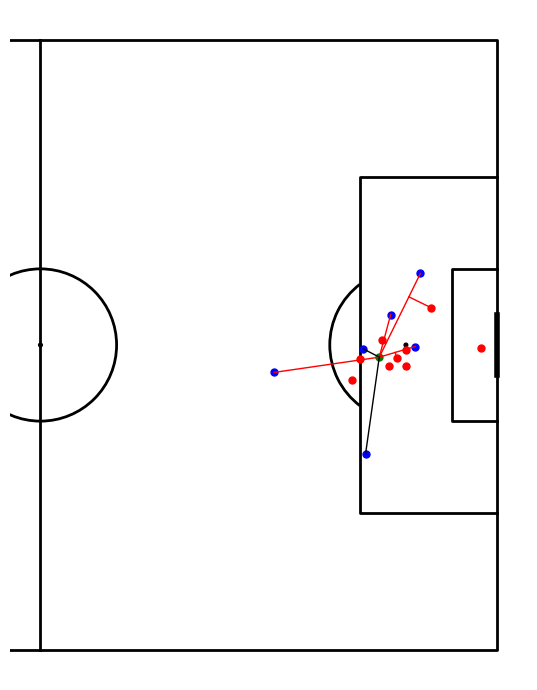

In [70]:
pitch = Pitch(line_color='black', half=True)
fig, ax = pitch.draw(figsize=(10, 7))
pitch.scatter(ball_location[0], ball_location[1], color='green', s=25, ax=ax)
for index, row in teammates.iterrows():
    pitch.scatter(row['location'][0], row['location'][1], color='blue', s=25, ax=ax)
    # pitch.text(row['location'][0] + 0.1, row['location'][1] + 0.1, f"({row['location'][0]}, {row['location'][1]})", 
    #         fontsize=9, color='black', ax=ax)

for index, row in opponents.iterrows():
    pitch.scatter(row['location'][0], row['location'][1], color='red', s=25, ax=ax)
    # pitch.text(row['location'][0] + 0.1, row['location'][1] + 0.1, f"({row['location'][0]}, {row['location'][1]})", 
    #         fontsize=9, color='black', ax=ax)
for index_t, row_t in teammates.iterrows():
    if row_t['intercepted'] == True:
        pitch.plot([row_t['location'][0], ball_location[0]], [row_t['location'][1], ball_location[1]], color='red', lw=1, ax=ax)
    elif row_t['intercepted'] == False:
        pitch.plot([row_t['location'][0], ball_location[0]], [row_t['location'][1], ball_location[1]], color='black', lw=1, ax=ax)
    m1 = (ball_location[1]-row_t['location'][1])/(ball_location[0]-row_t['location'][0])
    m2 = (-1)/m1
    c1 = row_t['location'][1] - row_t['location'][0]*m1
    for index_o, row_o in opponents.iterrows():
        c2 = row_o['location'][1] - row_o['location'][0]*m2
        crossover_x = (c2-c1)/(m1-m2)
        crossover_y = m1*crossover_x + c1
        ball_distance_to_crossover = (((ball_location[0]-crossover_x)**2)+(ball_location[1]-crossover_y)**2)**(1/2)
        player_distance_to_crossover = (((row_o['location'][0]-crossover_x)**2)+(row_o['location'][1]-crossover_y)**2)**(1/2)
        ball_time_to_crossover = ball_distance_to_crossover/12.2
        player_time_to_crossover = player_distance_to_crossover/6.84
        if row_t['location'][0] > ball_location[0]:
            if player_time_to_crossover < ball_time_to_crossover and crossover_x > ball_location[0] and crossover_x < row_t['location'][0]:
                intercepted_list.append(True)
                pitch.plot([row_o['location'][0], crossover_x], [row_o['location'][1], crossover_y], color='red', lw=1, ax=ax)
            else:
                intercepted_list.append(False)
        elif row_t['location'][0] < ball_location[0]:
            if player_time_to_crossover < ball_time_to_crossover and crossover_x < ball_location[0] and crossover_x > row_t['location'][0]:
                intercepted_list.append(True)
                pitch.plot([row_o['location'][0], crossover_x], [row_o['location'][1], crossover_y], color='red', lw=1, ax=ax)
            else:
                intercepted_list.append(False)


plt.show()

In [71]:
opponents

,location,player,position,teammate,distance
3,"[104.8, 39.4]","{'id': 15503, 'name': 'Jerdy Schouten'}","{'id': 9, 'name': 'Right Defensive Midfield'}",False,2.220360
4,"[102.0, 41.8]","{'id': 15582, 'name': 'Donyell Malen'}","{'id': 17, 'name': 'Right Wing'}",False,2.507987
7,"[117.8, 40.4]","{'id': 37274, 'name': 'Bart Verbruggen'}","{'id': 1, 'name': 'Goalkeeper'}",False,13.354026
8,"[108.0, 42.8]","{'id': 3669, 'name': 'Virgil van Dijk'}","{'id': 5, 'name': 'Left Center Back'}",False,3.700000
9,"[108.0, 40.7]","{'id': 7787, 'name': 'Stefan de Vrij'}","{'id': 3, 'name': 'Right Center Back'}",False,3.613862
10,"[111.3, 35.1]","{'id': 8125, 'name': 'Denzel Dumfries'}","{'id': 2, 'name': 'Right Back'}",False,9.406912
11,"[106.8, 41.7]","{'id': 21582, 'name': 'Tijjani Reijnders'}","{'id': 11, 'name': 'Left Defensive Midfield'}",False,2.302173
12,"[105.8, 42.8]","{'id': 3306, 'name': 'Nathan Aké'}","{'id': 6, 'name': 'Left Back'}",False,1.769181
13,"[100.9, 44.6]","{'id': 20750, 'name': 'Cody Mathès Gakpo'}","{'id': 21, 'name': 'Left Wing'}",False,4.686150


In [72]:
possible_shot_list = []
df_dicts = []
possible_shot_list.append(shot)
other_shots = teammates[teammates['intercepted'] == False]
for index_os, row_os in other_shots.iterrows():
    m1 = (40 - row_os['location'][1])/(120 - row_os['location'][0])
    pitch.plot([row_os['location'][0], 120], [row_os['location'][1], 40], color='black', lw=1, ax=ax)
    c1 = row_os['location'][1] - m1*row_os['location'][0]
    m2 = (-1)/m1
    shot_changeable = shot.copy()
    location_new = [row_os['location'][0], row_os['location'][1]]
    player_dict = row_os['player']
    player = player_dict['name']
    position_dict = row_os['position']
    position = position_dict['name']
    for index_o, row_o in opponents.iterrows():
        c2 = row_o['location'][1] - m2*row_o['location'][0]
        crossover_x = (c2-c1)/(m1-m2)
        crossover_y = m1*crossover_x + c1
        ball_distance_to_player = (((ball_location[0]-row_os['location'][0])**2)+(ball_location[1]-row_os['location'][1])**2)**(1/2)
        ball_time_to_player = ball_distance_to_player/19.5
        player_distance = ball_time_to_player*6.84
        player_distance_to_crossover = (((row_o['location'][0]-crossover_x)**2)+(row_o['location'][1]-crossover_y)**2)**(1/2)
        if player_distance_to_crossover < player_distance:
            player_location = [crossover_x, crossover_y]
            # opponents.loc[index_o, 'opponents_new_location_x'] = crossover_x
            # opponents.loc[index_o, 'opponents_new_location_y'] = crossover_y
            opponents.at[index_o, 'location'] = [crossover_x,crossover_y]
            continue
        elif player_distance_to_crossover > player_distance:
            if row_o['location'][1] > row_os['location'][1]:
                dx = player_distance/(math.sqrt(1+m2**2))
                ux = ((-(2*m2*c2 - 2*row_o['location'][1]*m2 - 2*row_o['location'][0])+(math.sqrt(((2*m2*c2 - 2*row_o['location'][1]*m2 - 2*row_o['location'][0])**2)-(4*((1+(m2**2))*(((row_o['location'][1])**2)-2*row_o['location'][1]*c2+(c2**2)+((row_o['location'][0])**2)-player_distance**2))))))/(2 * (1 + (m2**2))))
                uy = m2 * ux + c2
                # opponents.loc[index_o, 'opponents_new_location_x'] = ux
                # opponents.loc[index_o, 'opponents_new_location_y'] = uy
                opponents.at[index_o, 'location'] = [ux,uy]
            elif row_o['location'][1] < row_os['location'][1]:
                dx = -(player_distance/(math.sqrt(1+m2**2)))
                ux = ((-(2*m2*c2 - 2*row_o['location'][1]*m2 - 2*row_o['location'][0])-(math.sqrt(((2*m2*c2 - 2*row_o['location'][1]*m2 - 2*row_o['location'][0])**2)-(4*((1+(m2**2))*(((row_o['location'][1])**2)-2*row_o['location'][1]*c2+(c2**2)+((row_o['location'][0])**2)-player_distance**2))))))/(2 * (1 + (m2**2))))
                uy = m2 * ux + c2
                # opponents.loc[index_o, 'opponents_new_location_x'] = ux
                # opponents.loc[index_o, 'opponents_new_location_y'] = uy
                opponents.at[index_o, 'location'] = [ux,uy]

    df_dict_list = opponents.to_dict(orient='records')
    df_dicts.append(df_dict_list)
    shot_changeable['shot_freeze_frame'] = df_dict_list
    shot_changeable['location'] = location_new
    shot_changeable['player'] = player
    shot_changeable['position'] = position
    possible_shot_list.append(shot_changeable)

print(df_dicts)

possible_shot_df = pd.DataFrame(possible_shot_list)

possible_shot_df.to_csv('possible_shots.csv')
possible_shot_df


[[{'location': [104.77638587801472, 38.568782906118486], 'player': {'id': 15503, 'name': 'Jerdy Schouten'}, 'position': {'id': 9, 'name': 'Right Defensive Midfield'}, 'teammate': False, 'distance': 2.2203603311174542}, {'location': [102.02361412193275, 42.63121709203324], 'player': {'id': 15582, 'name': 'Donyell Malen'}, 'position': {'id': 17, 'name': 'Right Wing'}, 'teammate': False, 'distance': 2.50798724079689}, {'location': [117.7904196638818, 40.06277216863972], 'player': {'id': 37274, 'name': 'Bart Verbruggen'}, 'position': {'id': 1, 'name': 'Goalkeeper'}, 'teammate': False, 'distance': 13.354025610279468}, {'location': [108.02361412188019, 43.63121709018287], 'player': {'id': 3669, 'name': 'Virgil van Dijk'}, 'position': {'id': 5, 'name': 'Left Center Back'}, 'teammate': False, 'distance': 3.699999999999999}, {'location': [107.98980678042643, 40.34119867101061], 'player': {'id': 7787, 'name': 'Stefan de Vrij'}, 'position': {'id': 3, 'name': 'Right Center Back'}, 'teammate': Fals

,50_50,bad_behaviour_card,ball_receipt_outcome,block_deflection,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,goalkeeper_success_in_play,ball_recovery_offensive,dribble_no_touch,pass_miscommunication,player_off_permanent,goalkeeper_penalty_saved_to_post,goalkeeper_shot_saved_off_target,shot_follows_dribble,shot_saved_off_target,shot_redirect
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
# pitch = Pitch(line_color='black', half=True)
# fig, ax = pitch.draw(figsize=(10, 7))
# pitch.scatter(ball_location[0], ball_location[1], color='green', s=25, ax=ax)
# for index, row in teammates.iterrows():
#     pitch.scatter(row['location'][0], row['location'][1], color='blue', s=25, ax=ax)
#     # pitch.text(row['location'][0] + 0.1, row['location'][1] + 0.1, f"({row['location'][0]}, {row['location'][1]})", 
#     #         fontsize=9, color='black', ax=ax)

# for index, row in opponents.iterrows():
#     pitch.scatter(row['location'][0], row['location'][1], color='red', s=25, ax=ax)
#     # pitch.text(row['location'][0] + 0.1, row['location'][1] + 0.1, f"({row['location'][0]}, {row['location'][1]})", 
#     #         fontsize=9, color='black', ax=ax)


# other_shots = teammates[teammates['intercepted'] == False]
# other_shot = other_shots.iloc[0]
# m1 = (40 - other_shot['location'][1])/(120 - other_shot['location'][0])
# pitch.plot([other_shot['location'][0], 120], [other_shot['location'][1], 40], color='black', lw=1, ax=ax)
# c1 = other_shot['location'][1] - m1*other_shot['location'][0]
# m2 = (-1)/m1
# for index_o, row_o in opponents.iterrows():
#     c2 = row_o['location'][1] - m2*row_o['location'][0]
#     crossover_x = (c2-c1)/(m1-m2)
#     crossover_y = m1*crossover_x + c1
#     ball_distance_to_player = (((ball_location[0]-other_shot['location'][0])**2)+(ball_location[1]-other_shot['location'][1])**2)**(1/2)
#     ball_time_to_player = ball_distance_to_player/19.5
#     player_distance = ball_time_to_player*6.84
#     print(player_distance)
#     player_distance_to_crossover = (((row_o['location'][0]-crossover_x)**2)+(row_o['location'][1]-crossover_y)**2)**(1/2)
#     if player_distance_to_crossover < player_distance:
#         player_location = [crossover_x, crossover_y]
#         opponents.loc[index_o, 'opponents_new_location_x'] = crossover_x
#         opponents.loc[index_o, 'opponents_new_location_y'] = crossover_y
#         pitch.plot([row_o['location'][0], crossover_x], [row_o['location'][1], crossover_y], color='red', lw=1, ax=ax)
#         continue
#     elif player_distance_to_crossover > player_distance:
#         if row_o['location'][1] < other_shot['location'][1]:
#             # ux = row_o['location'][0] + player_distance*(math.sqrt(((1/1+m2**2))))
#             # uy = row_o['location'][1] + player_distance*(math.sqrt((m2/1+m2**2)))
#             dx = player_distance/(math.sqrt(1+m2**2))
#             ux = ((-(2*m2*c2 - 2*row_o['location'][1]*m2 - 2*row_o['location'][0])+(math.sqrt(((2*m2*c2 - 2*row_o['location'][1]*m2 - 2*row_o['location'][0])**2)-(4*((1+(m2**2))*(((row_o['location'][1])**2)-2*row_o['location'][1]*c2+(c2**2)+((row_o['location'][0])**2)-player_distance**2))))))/(2 * (1 + (m2**2))))
#             uy = m2 * ux + c2
#             opponents.loc[index_o, 'opponents_new_location_x'] = ux
#             opponents.loc[index_o, 'opponents_new_location_y'] = uy
#             dist = (((row_o['location'][0]-ux)**2)+((row_o['location'][1]-uy)**2))**(1/2)
#             print(dist)
#             pitch.plot([row_o['location'][0], ux], [row_o['location'][1], uy], color='red', lw=1, ax=ax)
#         elif row_o['location'][1] > other_shot['location'][1]:
#             # ux = row_o['location'][0] -player_distance*(math.sqrt(((1/1+m2**2))))
#             # uy = row_o['location'][1] -player_distance*(math.sqrt((m2/1+m2**2)))
#             dx = -(player_distance/(math.sqrt(1+m2**2)))
#             ux = ((-(2*m2*c2 - 2*row_o['location'][1]*m2 - 2*row_o['location'][0])-(math.sqrt(((2*m2*c2 - 2*row_o['location'][1]*m2 - 2*row_o['location'][0])**2)-(4*((1+(m2**2))*(((row_o['location'][1])**2)-2*row_o['location'][1]*c2+(c2**2)+((row_o['location'][0])**2)-player_distance**2))))))/(2 * (1 + (m2**2))))
#             uy = m2 * ux + c2
#             opponents.loc[index_o, 'opponents_new_location_x'] = ux
#             opponents.loc[index_o, 'opponents_new_location_y'] = uy
#             pitch.plot([row_o['location'][0], ux], [row_o['location'][1], uy], color='red', lw=1, ax=ax)
#             dist = (((row_o['location'][0]-ux)**2)+((row_o['location'][1]-uy)**2))**(1/2)
#             print(dist)
    

        
# plt.show()  
# opponents

